# Exercice on local approximation of an univariate quadratic expression using linear regression

Idea : 
- Perform linear regression analiticaly
- Perform linear regression with gradient descent (SGD)

In [3]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy as sy
import pandas

### Model

In [89]:
#
xMin = 0
xMax = 0.5
#
b = 0.35
std = 0.01
#
def generateBatch(N, stochastic = False):
    if stochastic:
        x = random.uniform(xMin, xMax, N)
    else:
        x = np.linspace(xMin, xMax, N)
    yClean = x**4 + (x-0.3)**3 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

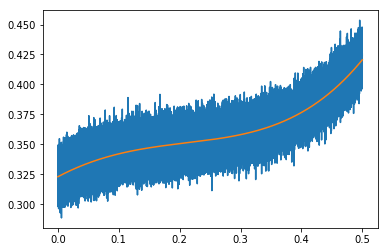

In [132]:
N = 100000
x, y, yClean = generateBatch(N)
plt.plot(x, y, x, yClean);

## Analiticaly

Remove biases

In [209]:
xUnB = x - np.mean(x)
yUnB = y - np.mean(y)

## Maison

Linear, 1st degree approximation of y:
\begin{align}
y = x w + b
\end{align}

- $x$ is a $N_{feature} * N_{sample}$ matrix 
- $w$ is a $N_{feature}$ vector
- $y$ is a $N_{sample}$ vector
- $b$ is a scalar

Let's define unbiased y:
\begin{align}
y_u = y - b = x w
\end{align}

Using mean square error (Euclidian norm), we are looking for $w_{est}$ such that:


\begin{align}
w_{est} = min_w \lVert x w - y_u \rVert_2^2
\end{align}

\begin{align}
L_2(w) & = \lVert x w - y_u \rVert_2^2 = (x w - y_u)^T(x w - y_u) \\
& = w^T x^T x w + y_u^T y_u - 2 x^T w^T y_u
\end{align}

Lookup the minimum through the partial derivate:

$$\frac{\partial{L_2(w)}}{\partial w} = 2 x^T x w - 2 x^T  y_u$$

If $x^T x$ can be inverted:
$$\frac{\partial{L_2(w)}}{\partial w} = 0 \iff w = (x^T x)^{-1} x^T y_u$$

In [213]:
# In case x is univariate, the matrix product x^T x is a scalar
xTxInv = 1/np.matmul(xUnB.T,xUnB)
w = xTxInv * np.matmul(xUnB.T, yUnB)
w

0.14498599438166024

In [211]:
bEst = np.mean(y - w * x)
bEst

0.32299543829276284

In [212]:
yEst1 = w*x + bEst

mse1 = 0.000149400889609


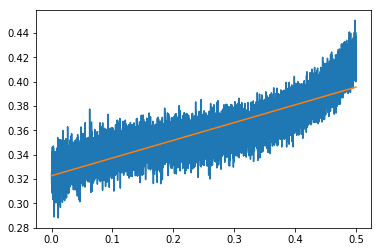

In [95]:
plt.plot(x, y, x, yEst1);
mse1 = np.dot(y-yEst1, y-yEst1) / N
print('mse1 =', mse1);

## Numpy polyfit, 1s degree
http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [96]:
fit2 = np.polyfit(x, y, 1)
fit2

array([ 0.14548617,  0.32270639])

In [97]:
yEst2 = fit2[0] * x + fit2[1]

mse2 = 0.000149400889609


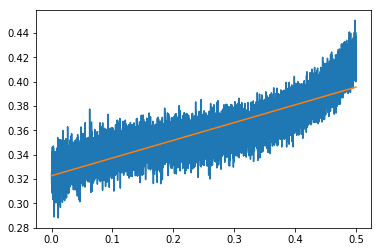

In [98]:
plt.plot(x, y, x, yEst2);
mse2 = metrics.mean_squared_error(y, yEst2)
print('mse2 =', mse2);

## Numpy polyfit, 4th degree

In [99]:
fit3 = np.polyfit(x, y, 4)
fit3

array([ 0.82064625,  1.22656622, -1.00106341,  0.2879605 ,  0.32192028])

In [100]:
yEst3 = x**4 * fit3[0] + x**3 * fit3[1] + x**2 * fit3[2] + x * fit3[3] + fit3[4]

mse3 = 0.000100508730712


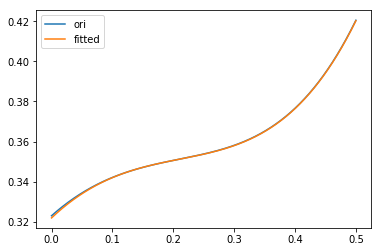

In [101]:
plt.plot(x, yClean, x, yEst3);
mse3 = metrics.mean_squared_error(y, yEst3)
plt.legend(['ori','fitted'])
print('mse3 =', mse3);

## NumPy least square

In [102]:
fit4, residues, rank, s = np.linalg.lstsq(np.reshape(xUnB, (N,1)), y - np.mean(y))
fit4

array([ 0.14548617])

In [103]:
yEst4 = fit4 * x + bEst

mse4 = 0.000149400889609


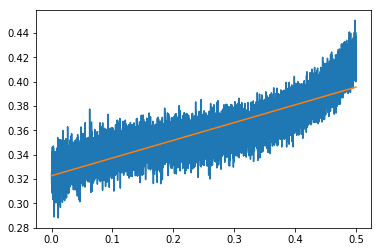

In [104]:
plt.plot(x, y, x, yEst4);
mse4 = metrics.mean_squared_error(y, yEst4)
print('mse4 =', mse4);

## Scipy

In [105]:
fit5 = sy.stats.linregress(x, y)
fit5

LinregressResult(slope=0.14548617045065573, intercept=0.3227063872486034, rvalue=0.86427544995834227, pvalue=0.0, stderr=0.00084683191039626492)

In [106]:
yEst5 = fit5.slope * x + fit5.intercept

mse3 = 0.000149400889609


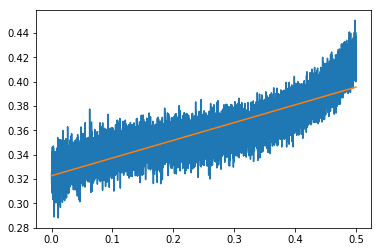

In [107]:
plt.plot(x, y, x, yEst5)
mse5 = metrics.mean_squared_error(y, yEst5) # HERK fit5.stderr**2 
print('mse3 =', mse5);

# Gradient descent

Plot MSE for several of the slope

In [108]:
Ns = 100
slope = np.linspace(-0.5, 0.5, Ns)

In [109]:
sx = np.matmul(np.reshape(xUnB, (N,1)), np.reshape(slope,(1,Ns)))
sx.shape

(10000, 100)

In [110]:
er_sx_y = sx - np.reshape(yUnB, (N, 1)) 
er_sx_y.shape

(10000, 100)

In [111]:
mse = np.mean(er_sx_y.T**2, axis = 1)
mse.shape

(100,)

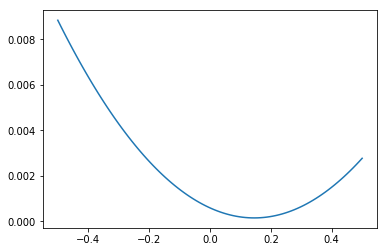

In [112]:
plt.plot(slope, mse)

In [113]:
np.min(mse)

0.00014942083975055928

### Gradient descent

In [198]:
w6 = 10
threshold = 1e-7
# learningRate = 0.09 # Aggresive
learningRate = 0.005 # Quick
gradient = np.matmul(xUnB.T, w6*xUnB - yUnB)
gradientNorm = gradient**2 # univariate
print('w start =', w6, ', Gradient norm =', gradientNorm)
w6Learn = [np.array([w6, gradientNorm])]
while gradientNorm > threshold:
    w6 = w6 - learningRate * gradient
    gradient = np.matmul(xUnB.T,(w6*xUnB-yUnB)) 
    gradientNorm = gradient**2
    # print('w =', w6, ', Gradient norm =', gradientNorm)
    w6Learn.append(np.array([w6,  gradientNorm]))
print('w end =', w6, ', Gradient norm =', gradientNorm, ', num iteration =', len(w6Learn))
df6 = pandas.DataFrame(w6Learn, columns = ('w', 'Gradient norm'))

w start = 10 , Gradient norm = 4216592.67205
w end = 0.1454849016 , Gradient norm = 6.99056069836e-08 , num iteration = 6


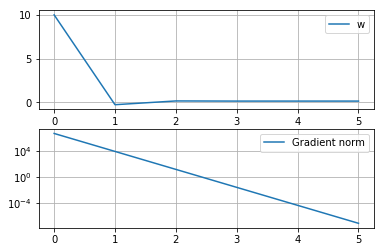

In [199]:
plt.subplot(2,1,1)
plt.plot(df6['w'])
plt.grid()
plt.legend();
plt.subplot(2,1,2)
plt.semilogy(df6['Gradient norm'])
plt.grid()
plt.legend();

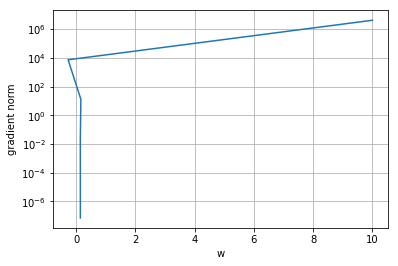

In [200]:
plt.semilogy(df6['w'], df6['Gradient norm'])
plt.grid()
plt.xlabel('w')
plt.ylabel('gradient norm');

In [201]:
yEst6 = w6*x + bEst

mse6 = 0.00014922875022


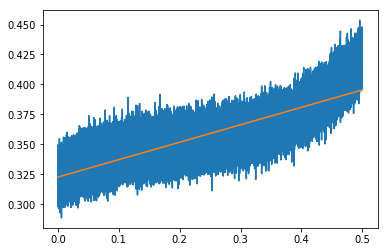

In [202]:
plt.plot(x, y, x, yEst6);
mse6 = metrics.mean_squared_error(y, yEst6)
print('mse6 =', mse6);

## Stochastic gradient descent

In [203]:
def calcGradient(x, y, w):
    _x = x - np.mean(x)
    _y = y - np.mean(y)
    gradient = np.matmul(_x.T, (w*_x - _y))
    return gradient

In [204]:
Nbatch = 100
w7 = 10
threshold = 1e-7
learningRate = 0.05
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch, True)
gradient = calcGradient(xBatch, yBatch, w7)
gradientNorm = gradient**2 # univariate
print('w start =', w7, ', Gradient norm =', gradientNorm)
w7Learn = [np.array([w7, gradientNorm])]
# Continue
while gradientNorm > threshold:
    w7 = w7 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch, True)
    gradient = calcGradient(xBatch, yBatch, w7)
    gradientNorm = gradient**2
    w7Learn.append(np.array([w7,  gradientNorm]))
    learningRate = learningRate * 0.99
print('w end =', w7, ', Gradient norm =', gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('w', 'Gradient norm'))

w start = 10 , Gradient norm = 330.120111302
w end = 0.145886487527 , Gradient norm = 1.13712341937e-08 , num iteration = 282


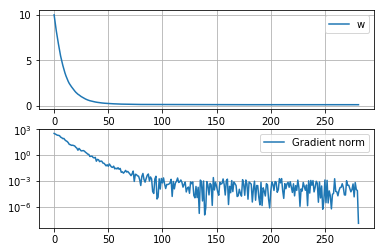

In [205]:
plt.subplot(2,1,1)
plt.plot(df7['w'])
plt.grid()
plt.legend();
plt.subplot(2,1,2)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.legend();

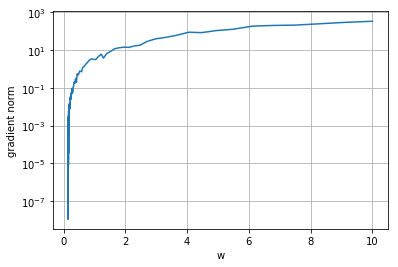

In [206]:
plt.semilogy(df7['w'], df7['Gradient norm'])
plt.xlabel('w')
plt.ylabel('gradient norm')
plt.grid();

In [207]:
yEst7 = w7*x + bEst

mse7 = 0.000149217542663


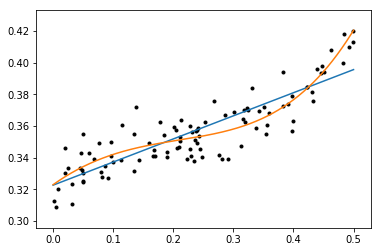

In [208]:
plt.scatter(xBatch, yBatch, marker='.', color = 'black');
plt.plot(x, yEst7)
plt.plot(x, yClean)
mse7 = metrics.mean_squared_error(y, yEst7)
print('mse7 =', mse7);